In [16]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedShuffleSplit
import xgboost as xgb
import numpy as np 
import os
import datetime
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

# Stratified random sampling

In [17]:
# Input model dataset
df1_data=pd.read_excel("Data sources/Model dataset/model_dataset.xlsx",sheet_name = "Sheet1")
df1_data

,gas,gas-2,gas-3,gas-log10-403,Type,Label,Unnamed: 6,(La/Sm)N,MORB-type2,MORB-type3,...,P8,K8,Na8 gongshi,Na8 calc,Na8,PM/P8,PM/P8 calc,Dilution8,K8/K90 calc,Dilution90
0,undegas,undegas,real all,undegas,glass,1,NMORB,0.536739,D-MORB,D-MORB,...,0.087396,0.055616,3.06000,NaN,3.060000,0.881049,NaN,0.881049,1.298920,1.298920
1,undegas,undegas,real all,undegas,glass,1,DMORB,0.371428,D-MORB,D-MORB,...,0.115102,0.090250,2.97920,NaN,2.979200,0.764540,NaN,0.764540,1.326012,1.326012
2,undegas,undegas,real all,undegas,glass,1,NaN,0.591159,D-MORB,D-MORB,...,0.102152,0.094178,NaN,3.683701,3.683701,0.799172,NaN,0.799172,1.294345,1.294345
3,undegas,undegas,real all,undegas,glass,1,NaN,0.434505,D-MORB,D-MORB,...,0.143656,0.035914,3.06947,NaN,3.069470,0.841783,NaN,0.841783,1.303935,1.303935
4,undegas,undegas,real all,undegas,glass,1,NaN,0.370160,D-MORB,D-MORB,...,0.083368,0.041684,NaN,2.810684,2.810684,0.839653,NaN,0.839653,1.355188,1.355188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,undegas,NaN,NaN,undegas,melt inclusion,2,NaN,0.684305,D-MORB,D-MORB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
444,undegas,NaN,NaN,undegas,melt inclusion,2,NaN,0.369308,D-MORB,D-MORB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
445,undegas,NaN,NaN,undegas,melt inclusion,2,NaN,0.718098,D-MORB,D-MORB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
446,undegas,NaN,NaN,undegas,melt inclusion,2,NaN,0.452402,D-MORB,D-MORB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Stratified random sampling
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=11)
# divide augmented X and y into training and testing data
for train_val_index, test_index in split1.split(df1_data, df1_data["Label"]):
    df_train_val = df1_data.loc[train_val_index]
    df_test = df1_data.loc[test_index]

# Model training and validation

In [19]:
df_train_val=pd.read_excel("Data sources/Model dataset/train+validation_dataset.xlsx", sheet_name="Sheet1")

In [20]:
#Set the hyperparameters of the XGBoost Regressor model
xgb = XGBRegressor()
model_xgb = XGBRegressor(base_score=0, booster ='gbtree',colsample_bylevel = None, colsample_bynode = None,max_delta_step = None,
                         reg_alpha = None,reg_lambda = None, tree_method = None,validate_parameters = None,num_parallel_tree = None,
                         colsample_bytree = 0.8, learning_rate = 0.1, subsample = None, max_depth = 5,min_child_weight = 30,
                         gamma = None,n_estimators = 200)

1000 times replications

In [104]:
# 1000-times replications result
list1 = []
list21 = []

repeat = 1000
for i in range(0,repeat): 
    # Split the training + validation set into a training set and a validation set (80：20).
    split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=None)
    for train_index, val_index in split2.split(df_train_val, df_train_val["Label"]):
        train_data = df_train_val.loc[train_index].reset_index(drop=True)
        val_data = df_train_val.loc[val_index].reset_index(drop=True)

    # Select input and output data
    X_train = train_data.loc[:,['Depth','SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MnO','K2O', 'MgO','Na2O','P2O5','CaO', 
                                'Ba','Nb','Rb','La','Ce','Th','U','Sm']]
    y_train = train_data["lg(CO2)"].copy()
    X_val = val_data.loc[:,['Depth','SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MnO','K2O', 'MgO','Na2O','P2O5','CaO', 
                                'Ba','Nb','Rb','La','Ce','Th','U','Sm']]
    y_val = val_data["lg(CO2)"].copy()

    model_xgb.fit(X_train,y_train)
    
    predict_train = model_xgb.predict(X_train)
    predict_val = model_xgb.predict(X_val)
    
    list1.append(r2_score(y_val, predict_val))
    #grid_ = grid.best_estimator_
    importance = model_xgb.feature_importances_
    list21.append(importance)
    
df1 = pd.DataFrame(list1)
# Output and save the MC predicted testing data results
#df11.to_excel("r2_test.xlsx”)

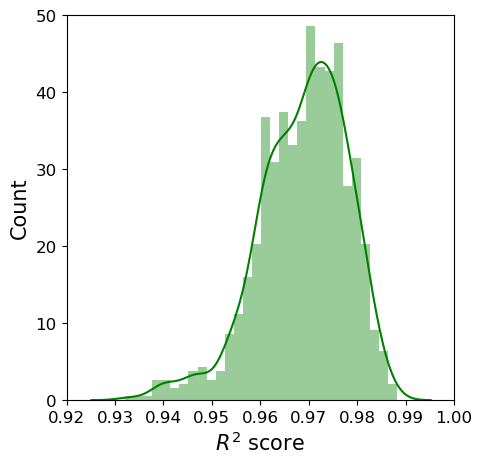

In [113]:
# 投分布图
plt.figure(figsize=(5,5),dpi=100)

ax1 = plt.subplot(111)
ax1 = sns.distplot(df1, hist = True, kde = True, bins = 30, color = 'green',
                   hist_kws = {'edgecolor':'None'}, kde_kws = {'linewidth':1.5})
ax1.set_xlim((0.92,1.0))
ax1.set_ylim((0,50))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax1.set_ylabel('Probability density', fontsize =15)
ax1.set_xlabel('$R^{2}$ score', fontsize =15)

#plt.savefig("MC_r2.svg", format='svg', dpi=600)
plt.show()

Five-fold-cross validation

In [7]:
# Select input and output data
X_train_val = df_train_val.loc[:,['Depth','SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MnO','K2O', 'MgO','Na2O','P2O5','CaO', 
                    'Ba','Nb','Rb','La','Ce','Th','U','Sm'
#                    'lg(Ba)', 'lg(Nb)', 'lg(Rb)', 'lg(La)', 'lg(Ce)', 'lg(Th)', 'lg(U)', 'lg(Sm)'
                   ]]
y_train_val = df_train_val["lg(CO2)"].copy()


X_train_val

,Depth,SiO2,TiO2,Al2O3,FeOT,MnO,K2O,MgO,Na2O,P2O5,CaO,Ba,Nb,Rb,La,Ce,Th,U,Sm
0,NaN,51.200000,0.760000,17.300000,7.700000,0.140000,0.050000,6.700000,2.000000,0.010000,14.000000,6.600000,0.800000,0.600000,1.500000,4.700000,NaN,0.020000,1.600000
1,NaN,48.894000,0.731000,15.807000,7.515000,0.173000,0.017000,9.349000,1.628000,0.032000,15.728000,3.017162,0.343270,NaN,0.615166,2.160012,NaN,NaN,1.480337
2,4350.0,48.969043,1.123791,16.233086,8.807554,0.148519,0.009901,9.295301,2.648582,0.103963,12.445861,0.404288,0.284061,NaN,1.282418,5.299845,NaN,NaN,2.515005
3,NaN,48.889000,0.722400,14.669000,9.209800,0.142459,0.000595,10.824000,1.624000,0.000523,13.528000,9.908000,1.401000,0.629639,1.489000,4.194000,0.065609,0.023364,1.380000
4,2750.0,49.591000,1.711000,16.961500,7.971000,0.160000,0.870360,7.464000,3.513000,0.419442,10.450000,229.730000,39.041000,21.175100,21.830000,40.430000,3.017300,0.706075,4.430000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,NaN,50.136000,0.780000,15.643000,6.953000,0.179000,0.003000,9.151000,1.814000,0.036000,15.162000,0.709033,0.096267,NaN,0.213984,1.612638,NaN,NaN,1.500401
354,2320.0,50.734100,0.896000,15.593100,8.862000,0.163000,0.026920,9.114000,1.989000,0.081380,13.140000,0.980000,0.306000,0.099600,0.860000,3.190000,0.018900,0.009045,1.750000
355,4441.0,50.910000,1.560000,14.460000,10.580000,0.200000,0.060000,7.710000,2.480000,0.120000,11.730000,2.437696,1.079683,0.243789,2.369353,9.495600,0.073580,0.024949,3.640594
356,2223.0,50.310000,1.160000,14.780000,10.500000,0.210000,0.080000,7.620000,2.430000,NaN,12.120000,28.750000,4.780000,2.440000,3.650000,9.140000,NaN,NaN,2.460000


In [8]:
# Five-fold-cross validation results
kfold = KFold (n_splits = 5, shuffle = True)
results = cross_val_score(model_xgb, X_train_val,y_train_val, scoring='r2', cv=5)
results

array([0.97286369, 0.97942456, 0.95024625, 0.97341172, 0.97473527])

Final model

In [8]:
#Train the model and get the final model
model_xgb.fit(X_train_val,y_train_val)

XGBRegressor(base_score=0, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=30, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Model test

In [9]:
#import test dateset
df_test=pd.read_excel("Data sources/Model dataset/test_dataset.xlsx", sheet_name="Sheet1")

# Select input and output data
X_test = df_test.loc[:,['Depth','SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MnO','K2O', 'MgO','Na2O','P2O5','CaO', 
                    'Ba','Nb','Rb','La','Ce','Th','U','Sm'
#                    'lg(Ba)', 'lg(Nb)', 'lg(Rb)', 'lg(La)', 'lg(Ce)', 'lg(Th)', 'lg(U)', 'lg(Sm)'
                   ]]
y_test = df_test["lg(CO2)"].copy()

X_test

,Depth,SiO2,TiO2,Al2O3,FeOT,MnO,K2O,MgO,Na2O,P2O5,CaO,Ba,Nb,Rb,La,Ce,Th,U,Sm
0,2750.0,48.531800,1.425000,17.087200,7.253000,0.141000,0.733250,8.009000,3.048000,0.328701,11.670000,223.010000,41.579000,18.498900,21.300000,37.710000,3.106200,0.676801,3.780000
1,3623.0,49.200287,0.888935,16.208024,7.896311,0.137403,0.031637,11.905743,2.114090,0.059862,11.437364,1.912467,0.656637,NaN,1.302065,4.291022,0.048902,0.021480,2.081996
2,3389.0,48.670000,0.970000,17.280000,7.940000,0.160000,NaN,9.790000,2.510000,NaN,11.970000,0.433395,0.228702,0.062551,1.110214,5.307452,NaN,NaN,1.984057
3,NaN,50.700000,0.790000,17.900000,7.400000,0.150000,0.060000,7.100000,1.900000,0.140000,14.200000,3.300000,0.300000,0.200000,1.000000,3.900000,NaN,0.010000,1.700000
4,NaN,48.553000,0.859000,16.449000,7.531000,0.178000,0.038000,9.355000,1.664000,0.034000,15.218000,7.778002,0.812130,NaN,0.912693,2.893065,NaN,NaN,1.322190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,NaN,50.190000,0.455800,12.823000,10.252000,NaN,NaN,11.848000,1.322000,NaN,12.792000,2.463034,0.420279,NaN,0.480260,1.815357,NaN,NaN,1.009972
86,3884.0,48.880000,0.920000,17.500000,7.770000,0.160000,0.030942,9.600000,2.400000,0.060000,12.220000,1.266970,0.506723,NaN,0.989983,3.811011,NaN,NaN,2.059477
87,3623.0,48.997698,0.926395,16.275446,8.396294,0.153982,0.041625,11.772076,2.426466,0.026916,10.801891,1.416583,0.555070,NaN,1.028099,3.686247,0.029481,0.028938,2.143396
88,NaN,51.800000,0.930000,18.600000,7.100000,0.150000,0.070000,4.500000,2.300000,0.130000,14.700000,6.900000,0.900000,0.800000,1.800000,5.200000,NaN,0.020000,1.700000


TEST RMSE =  0.198
TEST R2 = 0.972


<function matplotlib.pyplot.show(close=None, block=None)>

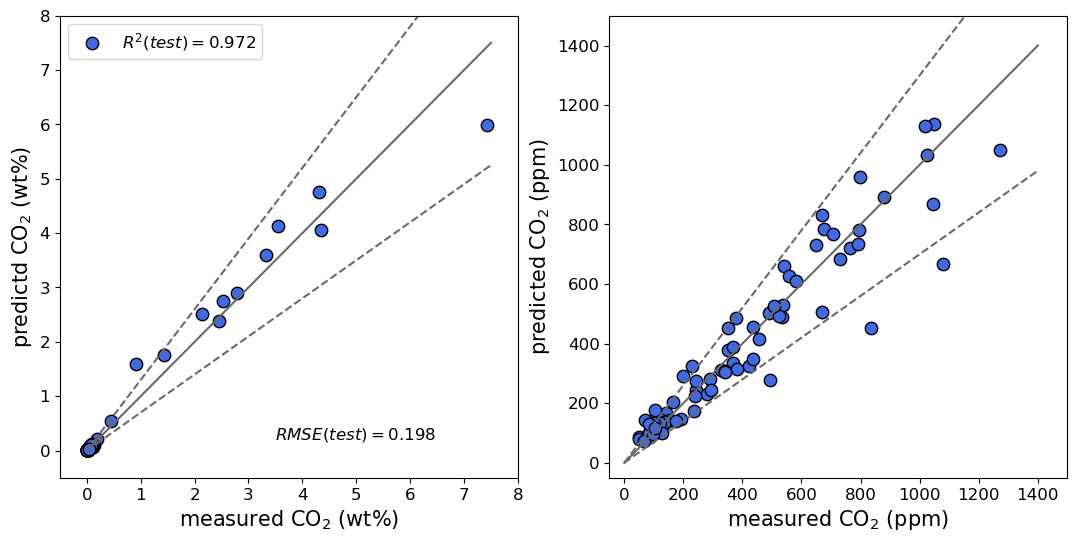

In [10]:
#Train the model and get the final model
model_xgb.fit(X_train_val,y_train_val)

# Get the scores of testing data
y_test_predict = model_xgb.predict(X_test)

y_test_predict_log = 10**(y_test_predict)/10000
y_test_log = 10**(y_test)/10000

test_rmse_log = np.around(np.sqrt(mean_squared_error(y_test_log, y_test_predict_log)), decimals=3)
test_r2_log = np.around(r2_score(y_test_log, y_test_predict_log), decimals=3)


print("TEST RMSE = ",test_rmse_log)
print("TEST R2 =",test_r2_log)


# Plot binary diagram
plt.figure(figsize = (13,6))

ax1 = plt.subplot(121)
p1 = max(max(y_test_predict_log),max(y_test_log))
p2 = min(min(y_test_predict_log),min(y_test_log))
plt.plot([0,7.5],[0,7.5],color = 'dimgrey', linestyle='-')
plt.plot([0,7.5],[0,5.25],color = 'dimgrey', linestyle='--')
plt.plot([0,7.5],[0,9.75],color = 'dimgrey', linestyle='--')
plt.xlabel('measured CO$_2$ (wt%)', fontsize =15)
plt.ylabel('predictd CO$_2$ (wt%)', fontsize =15)
plt.scatter(y_test_log,y_test_predict_log,marker='o',label=r'$R^2(test)=${}'.format(test_r2_log),  s=80,  color='royalblue',  edgecolors = 'black')
plt.xlim((-0.5,8))
plt.ylim((-0.5,8))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=12)

text_position = [6, 3]
plt.text(text_position[0]-2.5, text_position[1]-2.8,
             "$RMSE(test)=${}".format(test_rmse_log),
             fontdict={'size': 12, 'color': '#000000'})


y_test_predict_log = 10**(y_test_predict)
y_test_log = 10**(y_test)
ax2 = plt.subplot(122)
plt.plot([0,1400],[0,1400],color = 'dimgrey', linestyle='-')
plt.plot([0,1400],[0,1820],color = 'dimgrey', linestyle='--')
plt.plot([0,1400],[0,980],color = 'dimgrey', linestyle='--')
plt.xlabel('measured CO$_2$ (ppm)', fontsize =15)
plt.ylabel('predicted CO$_2$ (ppm)', fontsize =15)
plt.scatter(y_test_log,y_test_predict_log, marker='o',  s=80, color='royalblue',  edgecolors = 'black')
plt.ylim((-50,1500))
plt.xlim((-50,1500))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the figure
#plt.savefig("model.svg", format='svg', dpi=600)
plt.show

# Prediction via ML model

In [92]:
# Input the global dataset
df_prediction=pd.read_excel("Data sources/Implication dataset/global_dataset.xlsx",sheet_name = "Sheet1")
X_prediction = df_prediction.loc[:,['Depth','SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MnO','K2O', 'MgO','Na2O','P2O5','CaO', 
                    'Ba','Nb','Rb','La','Ce','Th','U','Sm']]
y_prediction_log = model_xgb.predict(X_prediction)
y_prediction = 10**(y_prediction_log)
df_prediction['CO2-ML'] = y_prediction
df= df_prediction
df
# Output and save the predicted results
#df.to_excel("global_CO2_ML.xlsx")